# Gaussian Mixture Model (GMM) for Customer Segmentation

**Objective:** Apply Gaussian Mixture Model clustering to segment customers and compare with K-Means.

**What is GMM?**
- **Probabilistic clustering:** Assumes data comes from a mixture of Gaussian distributions
- **Soft clustering:** Each point has a probability of belonging to each cluster (vs K-Means hard assignment)
- **Flexible shapes:** Can model elliptical clusters (vs K-Means circular clusters)
- **Model selection:** Uses BIC/AIC to determine optimal number of clusters

**Key Steps:**
1. Load preprocessed customer data
2. Find optimal number of clusters using BIC/AIC
3. Fit GMM model
4. Visualize clusters with PCA
5. Evaluate and compare with K-Means


In [ ]:
# Import necessary libraries for GMM clustering
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Visualization
from sklearn.mixture import GaussianMixture  # GMM clustering algorithm
from sklearn.decomposition import PCA  # Dimensionality reduction for visualization
from sklearn.neighbors import NearestNeighbors  # Not used in this notebook
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Clustering evaluation metrics

In [ ]:
# Load the preprocessed customer data
# Data is already cleaned, encoded, and ready for clustering
data = pd.read_csv("../Data/CustomersCleaned.csv")

## Step 1: Determine Optimal Number of Clusters

**Criteria for GMM:**
- **BIC (Bayesian Information Criterion):** Penalizes model complexity. Lower is better.
- **AIC (Akaike Information Criterion):** Similar to BIC, lower is better.
- **Log-Likelihood:** Higher is better (model fits data better)

Unlike K-Means elbow method, GMM uses statistical criteria to find the optimal k.


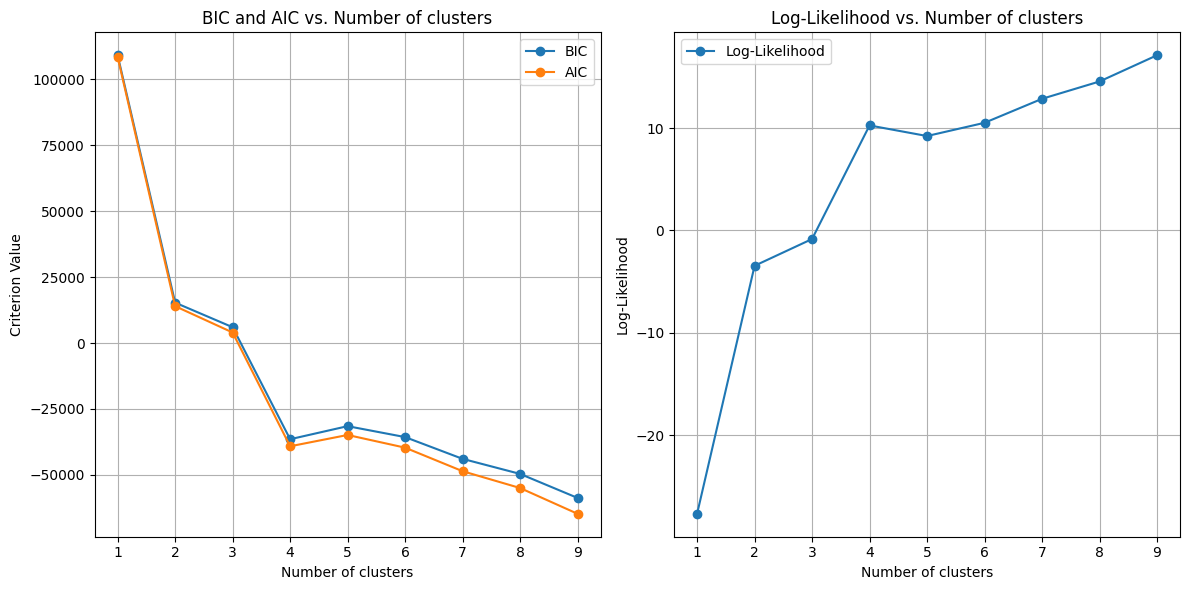

In [ ]:
# Test different numbers of clusters (1 to 9)
n_clusters = range(1, 10) 
log_likelihoods = []  # Store log-likelihood scores
bics = []  # Store BIC scores
aics = []  # Store AIC scores

# Fit GMM with different cluster numbers and calculate metrics
for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(data)
    log_likelihoods.append(gmm.score(data))  # Average log-likelihood (higher = better fit)
    bics.append(gmm.bic(data))  # BIC (lower = better, penalizes complexity)
    aics.append(gmm.aic(data))  # AIC (lower = better, less penalty than BIC)
    
# Create comparison plots
plt.figure(figsize=(12, 6))

# Plot 2: Log-Likelihood (higher is better)
plt.subplot(1, 2, 2)
plt.plot(n_clusters, log_likelihoods, marker="o", label="Log-Likelihood")
plt.title("Log-Likelihood vs. Number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.legend()

# Plot 1: BIC and AIC (lower is better)
# Look for the "elbow" or minimum point
plt.subplot(1, 2, 1)
plt.plot(n_clusters, bics, marker="o", label="BIC")
plt.plot(n_clusters, aics, marker="o", label="AIC")
plt.title("BIC and AIC vs. Number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Criterion Value")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## Step 2: Fit GMM with Optimal Clusters

Based on the BIC/AIC plots, we select **4 clusters** as optimal.


In [ ]:
# Create GMM model with 4 clusters
G = GaussianMixture(n_components=4, random_state=0)

# Fit the model and assign cluster labels
# GMM assigns each point to the cluster with highest probability
data["Cluster"] = G.fit_predict(data)

## Step 3: Visualize Clusters with PCA

Since we have many dimensions, we use PCA to reduce to 2D for visualization.


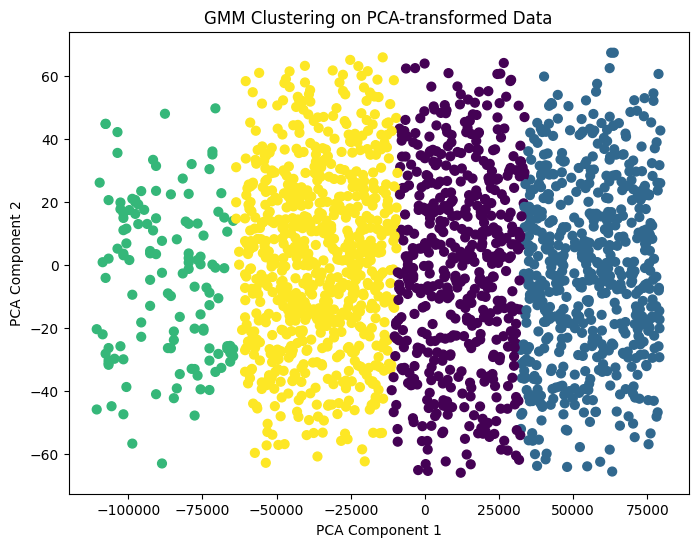

In [ ]:
# Apply PCA to reduce dimensions from many features to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Fit GMM on the 2D PCA data for visualization
gmm_pca = GaussianMixture(n_components=4, random_state=0)
PCAA = gmm_pca.fit_predict(data_pca)

# Create scatter plot with cluster colors
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=PCAA, cmap="viridis", s=40)
plt.title("GMM Clustering on PCA-transformed Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Step 4: Analyze Cluster Characteristics

Examine the average characteristics of each cluster.


In [ ]:
# Calculate statistics for each cluster
# Shows mean, min, and max for key customer attributes
# This helps understand what each cluster represents
data.groupby("Cluster")[["Age", "Annual Income", "Spending Score (1-100)"]].agg(["mean", "min", "max"]).round(2)

Age         Annual Income               Spending Score (1-100)      \
          mean min max          mean   min     max                   mean min   
Cluster                                                                         
0        50.85   0  99     109970.90  5000  189974                  48.46   0   
1        47.53   0  99     112623.81  3000  189689                  50.12   1   
2        48.61   0  99     109255.00     0  189709                  52.56   1   
3        51.16   0  99     110650.33  1000  186882                  52.94   1   

              
         max  
Cluster       
0        100  
1        100  
2        100  
3        100

## Step 5: Evaluate Clustering Quality

Use standard metrics to assess how well GMM separated the customers.

In [ ]:
# Prepare data for evaluation
X = data.drop("Cluster", axis=1)  # Features only
labels = data["Cluster"]  # Cluster assignments

# Calculate evaluation metrics
# Davies-Bouldin Index: Lower is better (measures cluster separation)
dbi_gmm = davies_bouldin_score(X, labels)

# Silhouette Score: Range [-1, 1], higher is better (measures cluster cohesion)
sil_score = silhouette_score(X, labels)

# Display the metrics
print(f"Silhouette Score: {sil_score:.2f}")
print(f"Davies-Bouldin Index: {dbi_gmm:.2f}")

Silhouette Score: -0.02
Davies-Bouldin Index: 93.66


## Model Comparison: GMM vs K-Means

### Performance Metrics:

| Metric | GMM | K-Means | Interpretation |
|--------|-----|---------|----------------|
| **Davies-Bouldin Index** | 93.66 | 0.56 | Lower is better |
| **Silhouette Score** | -0.02 | 0.56 | Higher is better (-1 to 1) |

### Analysis:

**GMM Performance:**
- **Silhouette Score: -0.02** ❌ Negative value indicates poor clustering - points are assigned to wrong clusters
- **Davies-Bouldin: 93.66** ❌ Extremely high value shows clusters are overlapping and poorly separated

**K-Means Performance:**
- **Silhouette Score: 0.56** ✅ Above 0.5 indicates good, well-defined clusters
- **Davies-Bouldin: 0.56** ✅ Low value indicates compact, well-separated clusters

### Conclusion: **K-Means is the Clear Winner** 🏆

**Why GMM Failed:**
1. **Data structure:** Customer data doesn't follow Gaussian distributions
2. **Spherical clusters:** This dataset has spherical cluster shapes, which K-Means handles better
3. **Overlapping:** GMM's probabilistic nature created overlapping clusters here

**Why K-Means Succeeded:**
1. **Simple cluster shapes:** Customer segments are naturally spherical
2. **Clear boundaries:** Distinct customer groups without overlap
3. **Appropriate algorithm:** K-Means is perfect for this type of data

**Recommendation:** Use **K-Means with 3 clusters** for customer segmentation in this dataset.